In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import os
from PIL import Image
from skimage import io
import numpy as np
import seaborn as sns
import cv2

In [2]:
csv_file = 'ddi_metadata_code.csv'#'fitzpatrick17k.csv'
df = pd.read_csv(csv_file)
# fig_folder = 'figures/'
# code_file = 'fitzpatrick17k_known_code.csv'  # this is to connect class number with class name
# code_df = pd.read_csv(code_file)

In [4]:
df

,Unnamed: 0,DDI_ID,DDI_file,skin_tone,malignant,disease
0,0,1,000001.png,56,True,melanoma-in-situ
1,1,2,000002.png,56,True,melanoma-in-situ
2,2,3,000003.png,56,True,mycosis-fungoides
3,3,4,000004.png,56,True,squamous-cell-carcinoma-in-situ
4,4,5,000005.png,12,True,basal-cell-carcinoma
...,...,...,...,...,...,...
651,651,652,000652.png,34,False,pyogenic-granuloma
652,652,653,000653.png,34,False,melanocytic-nevi
653,653,654,000654.png,34,False,acral-melanotic-macule
654,654,655,000655.png,34,True,squamous-cell-carcinoma


In [6]:
df['skin_tone'].value_counts()

34    241
12    208
56    207
Name: skin_tone, dtype: int64

In [7]:
df['disease'].value_counts()

melanocytic-nevi             119
seborrheic-keratosis          58
verruca-vulgaris              50
basal-cell-carcinoma          41
epidermal-cyst                35
                            ... 
keloid                         1
angioleiomyoma                 1
lymphocytic-infiltrations      1
wart                           1
acral-melanotic-macule         1
Name: disease, Length: 78, dtype: int64

In [8]:
df['malignant'].value_counts()

False    485
True     171
Name: malignant, dtype: int64

In [39]:
fitzpatrick_list = []
high_list = []
hash_list = []
for i in range(len(df)):
    high_list.append(int(df.iloc[i]['malignant']))
    skin_tone = df.iloc[i]['skin_tone']
    hash_list.append(df.iloc[i]['DDI_file'])
    if skin_tone == 12:
        fitzpatrick_list.append(1)
    elif skin_tone == 34:
        fitzpatrick_list.append(2)
    elif skin_tone == 56:
        fitzpatrick_list.append(3)
df['high'] = high_list
df['fitzpatrick'] = fitzpatrick_list
df['hasher'] = hash_list
df["low"] = df['disease'].astype('category').cat.codes
df

,Unnamed: 0,DDI_ID,DDI_file,skin_tone,malignant,disease,high,fitzpatrick,hasher,low
0,0,1,000001.png,56,True,melanoma-in-situ,1,3,000001.png,47
1,1,2,000002.png,56,True,melanoma-in-situ,1,3,000002.png,47
2,2,3,000003.png,56,True,mycosis-fungoides,1,3,000003.png,51
3,3,4,000004.png,56,True,squamous-cell-carcinoma-in-situ,1,3,000004.png,67
4,4,5,000005.png,12,True,basal-cell-carcinoma,1,1,000005.png,11
...,...,...,...,...,...,...,...,...,...,...
651,651,652,000652.png,34,False,pyogenic-granuloma,0,2,000652.png,59
652,652,653,000653.png,34,False,melanocytic-nevi,0,2,000653.png,44
653,653,654,000654.png,34,False,acral-melanotic-macule,0,2,000654.png,4
654,654,655,000655.png,34,True,squamous-cell-carcinoma,1,2,000655.png,66


In [40]:
df.to_csv('ddi_metadata_code.csv', index=False)

In [36]:
path = os.path.join("/bigdata/siyiplace/data/skin_lesion/ddidiversedermatologyimages/",str(df.loc[df.index[5],'hasher']))
print(path)

/bigdata/siyiplace/data/skin_lesion/ddidiversedermatologyimages/000006


In [3]:
'''
calculate weights for each skin type and condition
method 1 reweighting
'''
level = 'high'
total = df['fitzpatrick'].count()  # total samples
type_count = df['fitzpatrick'].value_counts().sort_index()
condition_count = df[level].value_counts().sort_index()
print(total)
print(type_count)
print(type_count[1])
print(condition_count)
weight_record = np.zeros((4, 2))
num_record = np.zeros((4, 2))
for i in range(1, 4): # skin type
    for j in range(len(condition_count)): # skin condition
        x = df.loc[(df['fitzpatrick']==i) & (df[level]==j)]
        num_record[i, j] = len(x)
        # print('joint num', len(x))
        weight = type_count[i]*condition_count[j]/(len(x)*total)
        # print('weight', weight)
        weight_record[i, j] = weight
print(weight_record)
print(num_record)
# add weights to the csv file
weight_list = []  # weight for each sample in the code_df
for k in range(total):
    row_data = df.iloc[k]
    # print(row_data)
    weight_list.append(weight_record[int(row_data['fitzpatrick']), int(row_data[level])])
    # print(weight_list)
print(len(weight_list))
df['REWT_weights'] = weight_list

656
1    208
2    241
3    207
Name: fitzpatrick, dtype: int64
208
0    485
1    171
Name: high, dtype: int64
[[0.         0.        ]
 [0.96717288 1.10652066]
 [1.06693625 0.84894117]
 [0.96252301 1.12414253]]
[[  0.   0.]
 [159.  49.]
 [167.  74.]
 [159.  48.]]
656


In [4]:
'''
calculate weights for each skin type and condition
method 2 resampling   weight=1/num
'''
level = 'high'
total = df['fitzpatrick'].count()  # total samples
type_count = df['fitzpatrick'].value_counts().sort_index()
condition_count = df[level].value_counts().sort_index()
weight_record = np.zeros((4, 3))
num_record = np.zeros((4, 3))
for i in range(1, 4): # skin type
    for j in range(len(condition_count)): # skin condition
        x = df.loc[(df['fitzpatrick']==i) & (df[level]==j)]
        num_record[i, j] = len(x)
        # print('joint num', len(x))
        weight = 1/len(x)
        # print('weight', weight)
        weight_record[i, j] = weight
# print(num_record)
print(weight_record)
# add weights to the csv file
weight_list = []  # weight for each sample in the code_df
for k in range(total):
    row_data = df.iloc[k]
    # print(row_data)
    weight_list.append(weight_record[int(row_data['fitzpatrick']), int(row_data[level])])
    # print(weight_list)
print(len(weight_list))
df['RESM_weights'] = weight_list

[[0.         0.         0.        ]
 [0.00628931 0.02040816 0.        ]
 [0.00598802 0.01351351 0.        ]
 [0.00628931 0.02083333 0.        ]]
656


In [5]:
df.to_csv(csv_file)

In [12]:
df.to_csv('ddi_metadata_code.csv', index=False)

In [5]:
# get number of samples per skin type per class  out  unknown type
np.set_printoptions(suppress=True)
label = 'high'
# fig_folder = 'figures/'
df = pd.read_csv('ddi_metadata_code.csv')
whole = np.zeros((3, len(df[label].unique())))  # whole samples

for i in range(df.shape[0]):
    row = df.iloc[i]
    type = int(row['fitzpatrick'])-1
    whole[type, row[label]] += 1

# calculate row 7. sum row 0-6        
# whole[7, :] = np.sum(whole[0:7, :], axis=0)
print(whole)
print(np.sum(whole, axis=0))
print(np.sum(whole, axis=1))
print(np.sum(whole)) 
# plot
# plt.figure(figsize=(100,8), dpi=200)
# sns.heatmap(record_array[0:7, :], annot=True, fmt=".2g", linewidths=.5)
# sns.heatmap(whole, annot=True, fmt=".2g", linewidths=.5)
# plt.xlabel('label')
# plt.ylabel('skin type')
# name = 'train__class_statistic_{}'.format(label)
# plt.title(name)
# # plt.savefig(fig_folder+name+'.jpg')
# plt.show()

[[159.  49.]
 [167.  74.]
 [159.  48.]]
[485. 171.]
[208. 241. 207.]
656.0


(458, 323, 3)


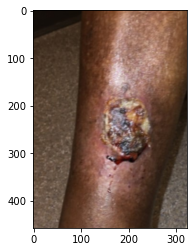

In [60]:
img_path = '/bigdata/siyiplace/data/skin_lesion/ddidiversedermatologyimages/000006.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = io.imread(img_path)
img_array = np.asarray(img, dtype=np.float32)
print(img_array.shape)
plt.imshow(img)